In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('adult.csv')
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [3]:
df.shape

(32561, 15)

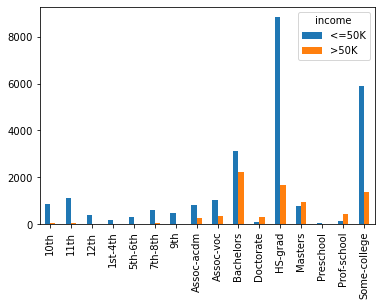

In [4]:
df.groupby(['education','income'])['income'].count().unstack().plot(kind='bar')
plt.xlabel("");

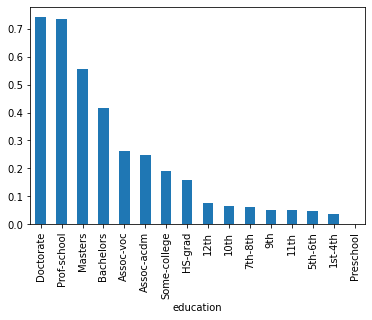

In [5]:
money_education = df.groupby(['education','income'])['income'].count().unstack()
money_education['ratio'] = money_education['>50K']/money_education.sum(axis=1)
money_education.sort_values('ratio',ascending=False).ratio.plot(kind='bar');

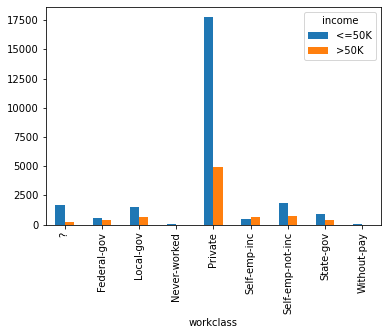

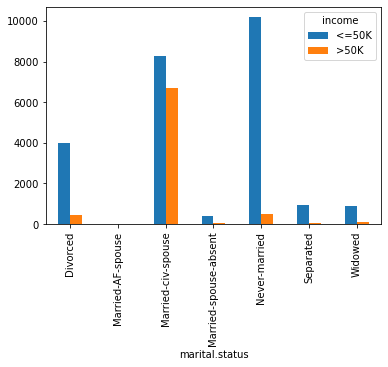

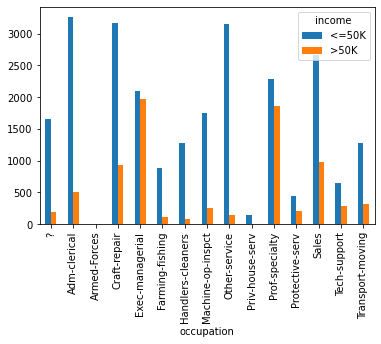

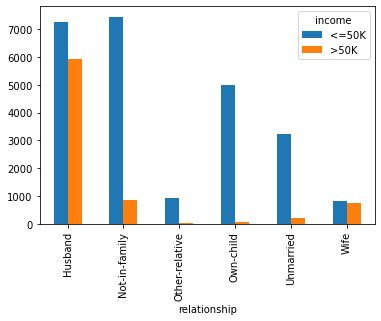

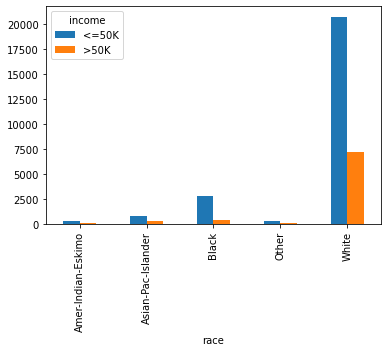

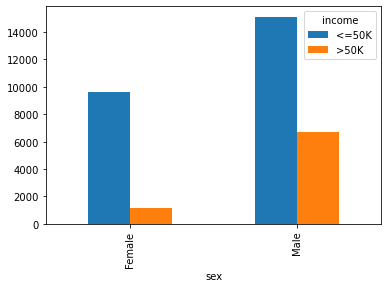

In [6]:
for i in ['workclass','marital.status','occupation','relationship','race','sex']:
    df.groupby([i,'income'])['income'].count().unstack().plot(kind='bar')

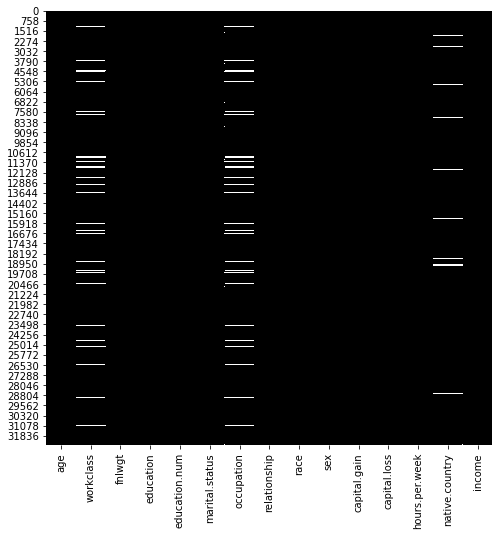

In [7]:
clean_df = df.copy()
clean_df.replace('?',np.nan,inplace=True)
plt.figure(figsize=(8,8))
sns.heatmap(clean_df.isnull(),cmap='binary_r',cbar=False);


There are some columns with null values, plus, as expected, workclass and occupation show the same null values pattern. Let's see the percentage of these values versus the overall data and evaluate whether they can be dropped

In [8]:
clean_df.occupation.isnull().sum()/clean_df.shape[0]*100

5.660145572924664

In [9]:
clean_df.workclass.isnull().sum()/clean_df.shape[0]*100

5.638647461687294

In [10]:
clean_df['native.country'].isna().sum()/clean_df.shape[0]*100

1.7904855501980899

Looks like they can be dropped

In [11]:
clean_df.dropna(axis=1,inplace=True)
clean_df.isnull().sum()

age               0
fnlwgt            0
education         0
education.num     0
marital.status    0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
income            0
dtype: int64

In [12]:
clean_df.drop('fnlwgt',axis=1,inplace=True)

In [13]:
from sklearn.preprocessing import StandardScaler, RobustScaler

In [14]:
standard_scaler = StandardScaler()
clean_df[clean_df.select_dtypes('int64').columns] = standard_scaler.fit_transform(clean_df[clean_df.select_dtypes('int64').columns])

In [15]:
print('Example mean after standardization: {:.2f}'.format(clean_df.iloc[:,0].mean()))
print('Example std after standardization: {:.2f}'.format(clean_df.iloc[:,0].std()))

Example mean after standardization: 0.00
Example std after standardization: 1.00


In [16]:
clean_df['income'] = clean_df.income.str.replace('<=50K','0').str.replace('>50K','1').astype(int)

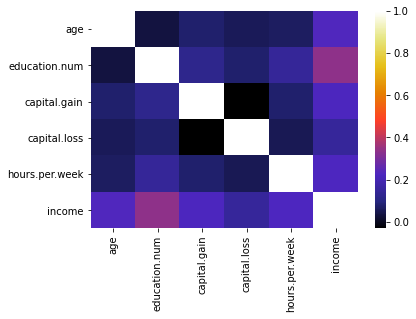

In [17]:
sns.heatmap(clean_df.corr(),cmap='CMRmap');

In [18]:
clean_df.columns

Index(['age', 'education', 'education.num', 'marital.status', 'relationship',
       'race', 'sex', 'capital.gain', 'capital.loss', 'hours.per.week',
       'income'],
      dtype='object')

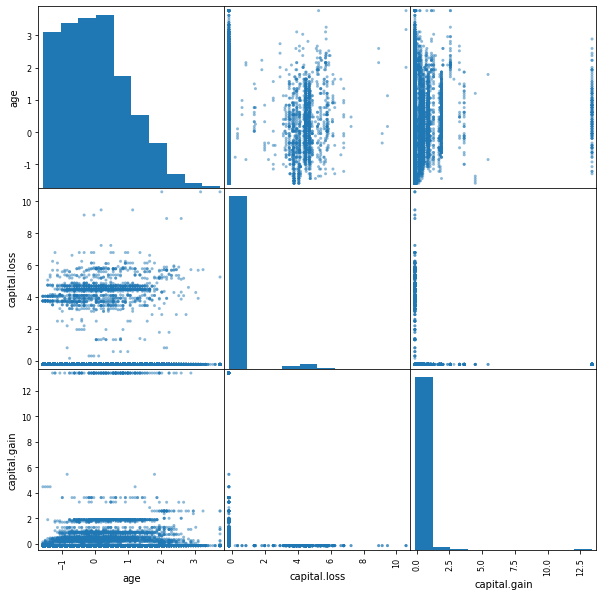

In [19]:
from pandas.plotting import scatter_matrix
scatter_matrix(clean_df[['age','capital.loss','capital.gain']],figsize=(10,10));

The correlation among numerical features seems to be weak

In [20]:
clean_df.drop('education',axis=1,inplace=True)

In [21]:
df_new = pd.get_dummies(clean_df)
df_new.head()

,age,education.num,capital.gain,capital.loss,hours.per.week,income,marital.status_Divorced,marital.status_Married-AF-spouse,marital.status_Married-civ-spouse,marital.status_Married-spouse-absent,...,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Female,sex_Male
0,3.769612,-0.420060,-0.14592,10.593507,-0.035429,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
1,3.183112,-0.420060,-0.14592,10.593507,-1.817204,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
2,2.010110,-0.031360,-0.14592,10.593507,-0.035429,0,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0
3,1.130359,-2.363558,-0.14592,9.461864,-0.035429,0,1,0,0,0,...,0,1,0,0,0,0,0,1,1,0
4,0.177296,-0.031360,-0.14592,9.461864,-0.035429,0,0,0,0,0,...,1,0,0,0,0,0,0,1,1,0


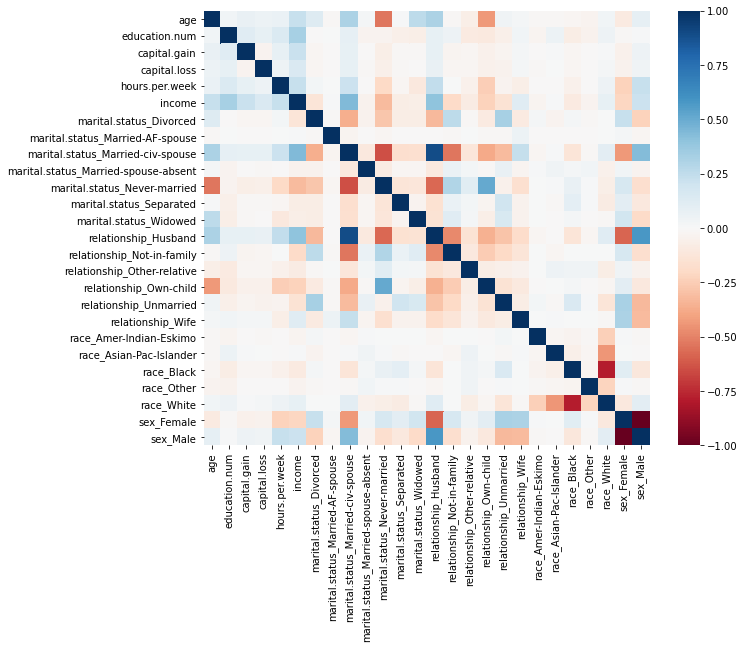

In [22]:
plt.figure(figsize=(10,8))
sns.heatmap(df_new.corr(),cmap='RdBu');

In [23]:
X = df_new.drop('income',axis=1).values
y = df_new.income.values

# KNeighborsClassifier

In [24]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, f1_score

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X,y,shuffle=True,test_size=0.2,random_state=8)

In [26]:
acc_test = []
acc_train = []
for k in (range(1,17)):
    knn=KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,y_train)
    pred_knn_test = knn.predict(X_test)
    pred_knn_train = knn.predict(X_train)
    acc_test.append(balanced_accuracy_score(y_test,pred_knn_test))
    acc_train.append(balanced_accuracy_score(y_train,pred_knn_train))

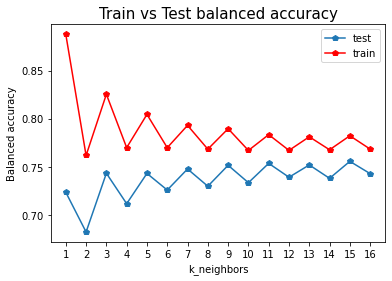

In [27]:
plt.plot(range(1,17), acc_test, 'p-', label='test')
plt.plot(range(1,17), acc_train, 'rp-', label='train')
plt.xticks(range(1,17));
plt.legend()
plt.xlabel('k_neighbors')
plt.ylabel('Balanced accuracy')
plt.title('Train vs Test balanced accuracy',{'fontsize':15});


In [28]:
from sklearn.metrics import roc_auc_score, roc_curve

In [29]:
knc = KNeighborsClassifier(n_neighbors=15)
knc.fit(X_train,y_train)
preds_k_15 = knc.predict(X_test)
preds_prob_k_15 = knc.predict_proba(X_test)[:,1]
fpr_k_15, tpr_k_15, tresholds_k_15 = roc_curve(y_test,preds_prob_k_15)
auc_score_k_15 = roc_auc_score(y_test,preds_prob_k_15)


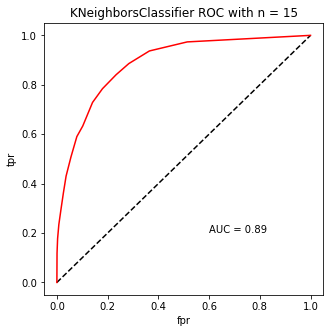

In [30]:
plt.figure(figsize=(5,5))
plt.plot([0,1],'k--')
plt.plot(fpr_k_15,tpr_k_15,'r')
plt.title('KNeighborsClassifier ROC with n = 15')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.annotate('AUC = {:.2f}'.format(auc_score_k_15),xy=(0.6,0.2));

# DecisionTreeClassifier

In [31]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [32]:
dt = DecisionTreeClassifier()

params = {'criterion':['gini','entropy'],
          'max_depth':[1,2,3,4,5],
          'min_samples_split': [2,3,4,5,6],
          'min_samples_leaf':[1,2,3,4,5]}

tree_model = GridSearchCV(estimator=dt, param_grid=params, cv = 10, n_jobs=-1,scoring='balanced_accuracy')
tree_model.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5],
                         'min_samples_leaf': [1, 2, 3, 4, 5],
                         'min_samples_split': [2, 3, 4, 5, 6]},
             scoring='balanced_accuracy')

In [33]:
print('best_params:',tree_model.best_params_)
print('best_score: ',tree_model.best_score_)

best_params: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
best_score:  0.7331327770926381


In [34]:
tree_preds = tree_model.predict(X_test)

In [35]:
tree_preds_prob = tree_model.predict_proba(X_test)[:,1]

In [36]:
print('Balanced accuracy: {:.2f}'.format(balanced_accuracy_score(y_test,tree_preds)))

Balanced accuracy: 0.73


In [37]:
fpr_tree, tpr_tree, tresholds_tree = roc_curve(y_test,tree_preds_prob)

In [38]:
auc_score_tree = roc_auc_score(y_test,tree_preds_prob)

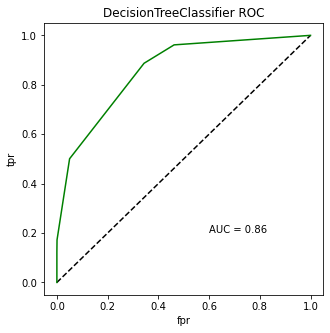

In [39]:
plt.figure(figsize=(5,5))
plt.plot([0,1],'k--')
plt.plot(fpr_tree,tpr_tree,'g')
plt.title('DecisionTreeClassifier ROC')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.annotate('AUC = {:.2f}'.format(auc_score_tree),xy=(0.6,0.2));

## LogisticRegression

In [40]:
from sklearn.linear_model import LogisticRegression


In [41]:
df_new.corr()['income'][(df_new.corr()['income']>0.3) | (df_new.corr()['income']<-0.3)]

education.num                        0.335154
income                               1.000000
marital.status_Married-civ-spouse    0.444696
marital.status_Never-married        -0.318440
relationship_Husband                 0.401035
Name: income, dtype: float64

Above the fetures that are linearlly correlated with income the most 

In [42]:
X_logr = df_new.drop('income',axis=1).values
y_logr = df_new['income']

X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_logr,y_logr,test_size=0.2,random_state=6)

In [43]:
logr = LogisticRegression()
logr.fit(X_train_lr, y_train_lr)
preds_logr = logr.predict(X_test_lr)
preds_prob_logr =logr.predict_proba(X_test_lr)[:,1]


C:\Users\Ettore\Documents\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [44]:
fpr_log, tpr_log, tresholds_log = roc_curve(y_test_lr,preds_prob_logr)
auc_score_log = roc_auc_score(y_test_lr,preds_prob_logr)

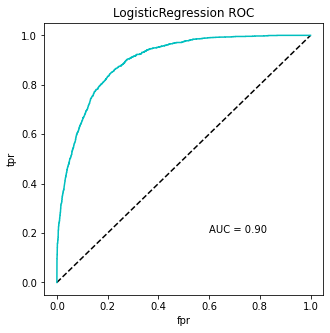

In [45]:
plt.figure(figsize=(5,5))
plt.plot([0,1],'k--')
plt.plot(fpr_log,tpr_log,'c')
plt.title('LogisticRegression ROC')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.annotate('AUC = {:.2f}'.format(auc_score_log),xy=(0.6,0.2));

## Ensemble method: Random Forests

In [46]:
from sklearn.ensemble import RandomForestClassifier

In [47]:
rf = RandomForestClassifier(n_estimators=200)
rf.fit(X_train,y_train)
rf_preds=rf.predict(X_test)
rf_pred_probs = rf.predict_proba(X_test)[:,1]

In [48]:
balanced_accuracy_score(y_test,rf_preds)

0.7616539328156796

In [49]:
fpr_rf, tpr_rf, tresholds_rf = roc_curve(y_test,rf_pred_probs)
auc_score_rf = roc_auc_score(y_test,rf_pred_probs)

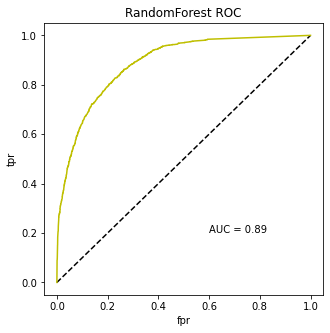

In [50]:
plt.figure(figsize=(5,5))
plt.plot([0,1],'k--')
plt.plot(fpr_rf,tpr_rf,'y')
plt.title('RandomForest ROC')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.annotate('AUC = {:.2f}'.format(auc_score_rf),xy=(0.6,0.2));

### Features importances in RandomForest

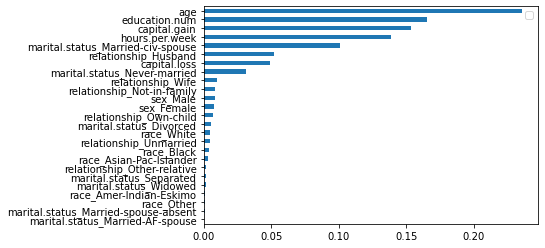

In [51]:
pd.DataFrame(rf.feature_importances_, index=df_new.drop('income',axis=1).columns).sort_values(by=0).plot(kind='barh')
plt.legend("");

## Comparing ROC - AUC of all models

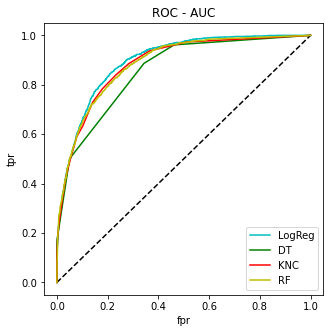

In [52]:
plt.figure(figsize=(5,5))
plt.plot([0,1],'k--')
plt.plot(fpr_log,tpr_log,'c',label='LogReg')
plt.plot(fpr_tree,tpr_tree,'g', label='DT')
plt.plot(fpr_k_15,tpr_k_15,'r', label='KNC')
plt.plot(fpr_rf,tpr_rf,'y',label='RF')
plt.title('ROC - AUC')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.legend();

Looks like LogisticRegression performed better